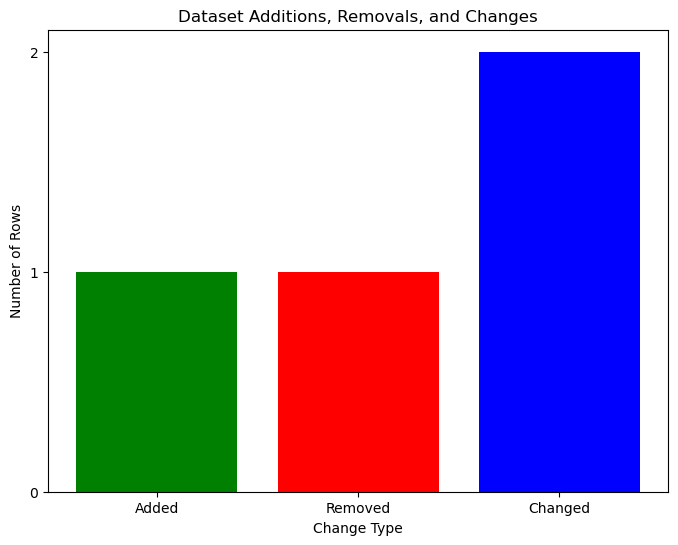

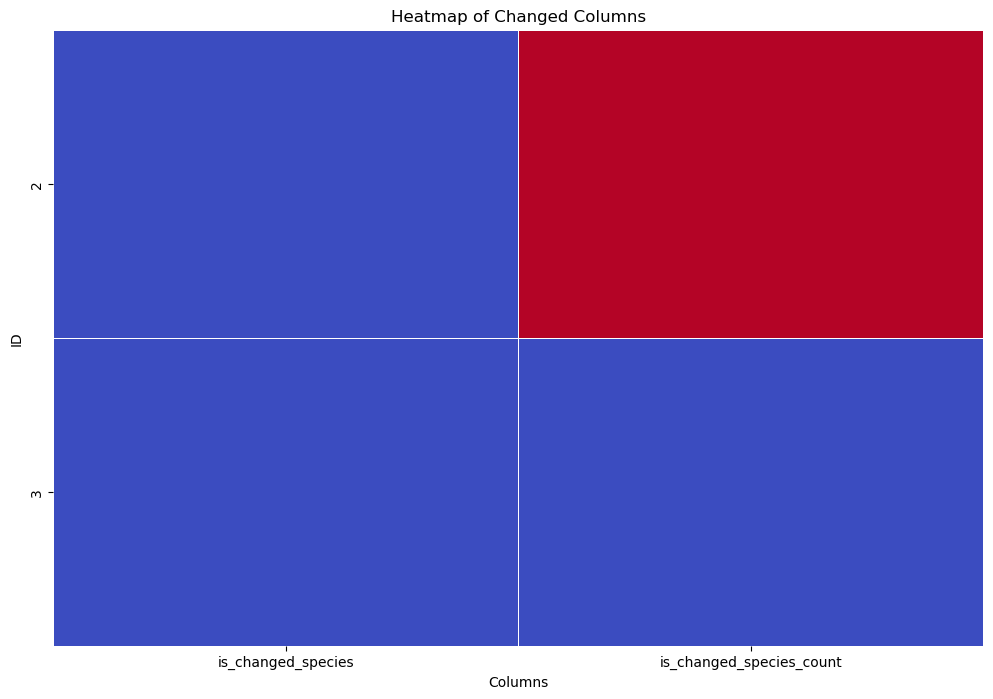

Combined Added and Removed Rows with Conditional Formatting:


,id,species,species_count,Row
0,4,salmon,4.000000,Added
1,1,salmon,1.000000,Removed


Changed Rows (Retaining Old and New Values with Conditional Formatting):


,id,species_old,species_count_old,species_new,species_count_new,_merge,is_changed_species,is_changed_species_count
0,2,pollock,5.000000,pollock,6.000000,both,False,True
1,3,salmon,2.000000,salmon,2.000000,both,False,False


ID: 2 - Changed Columns: ['species_count']


id                     2
species_count_old    5.0
species_count_new    6.0
Name: 0, dtype: object

Summary of Changes for each Column:


,Column,Number of Changes
1,is_changed_species_count,1
0,is_changed_species,0


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Example: Loading two CSV files into DataFrames
df_old = pd.read_csv('data-sources/row-all-operations.csv')
df_new = pd.read_csv('data-sources/row-all-operations-diff.csv')

# Step 2: Identify Added, Removed, and Changed Rows
# Merge on unique identifier (e.g., 'id')
merged = df_old.merge(df_new, on='id', how='outer', suffixes=('_old', '_new'), indicator=True)

# For "Added" rows (right_only): drop "_old" columns and rename "_new" columns
added_rows = merged[merged['_merge'] == 'right_only'].copy()
added_rows = added_rows.drop(columns=[col for col in added_rows.columns if '_old' in col])
added_rows = added_rows.rename(columns=lambda x: x.replace('_new', ''))

# For "Removed" rows (left_only): drop "_new" columns and rename "_old" columns
removed_rows = merged[merged['_merge'] == 'left_only'].copy()
removed_rows = removed_rows.drop(columns=[col for col in removed_rows.columns if '_new' in col])
removed_rows = removed_rows.rename(columns=lambda x: x.replace('_old', ''))

# Step 2: Combine the "Added" and "Removed" rows
combined_rows = pd.concat([added_rows, removed_rows], ignore_index=True)

# Fix the categorical _merge column using rename_categories()
combined_rows['_merge'] = combined_rows['_merge'].cat.rename_categories({
    'right_only': 'Added', 
    'left_only': 'Removed'
})

# Rename the _merge column to "Row"
combined_rows = combined_rows.rename(columns={'_merge': 'Row'})

# Step 3: Reset index and display the final DataFrame
combined_rows = combined_rows.reset_index(drop=True)

# List of columns to compare (excluding 'id')
columns_to_compare = df_old.columns.difference(['id'])
changed_rows = merged[merged['_merge'] == 'both'].copy()

# Iterate over each column to compare
for column in columns_to_compare:
    old_col = column + '_old'
    new_col = column + '_new'
    # Create a boolean column to indicate if the value changed using .loc
    changed_rows.loc[:, 'is_changed_' + column] = changed_rows[old_col] != changed_rows[new_col]



# Data for the bar chart
change_summary = pd.DataFrame({
    'Change Type': ['Added', 'Removed', 'Changed'],
    'Count': [len(added_rows), len(removed_rows), len(changed_rows)]
})

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(change_summary['Change Type'], change_summary['Count'], color=['green', 'red', 'blue'])
plt.xlabel('Change Type')
plt.ylabel('Number of Rows')
plt.title('Dataset Additions, Removals, and Changes')

# Ensure y-axis uses integers
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Show the plot
plt.show()

# Visualization of Changed Columns with a Heatmap

# Create a matrix to visualize the changes (1 if changed, 0 if not)
change_matrix = changed_rows.set_index('id')[['is_changed_' + col for col in columns_to_compare]].astype(int)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(change_matrix, cmap="coolwarm", cbar=False, linewidths=0.5)
plt.title('Heatmap of Changed Columns')
plt.xlabel('Columns')
plt.ylabel('ID')
plt.show()

# Step 3: Define a function to apply conditional formatting
# Step 3: Define a function to apply lighter conditional formatting
def highlight_rows(row):
    if row['Row'] == 'Added':
        return ['background-color: #ccffcc'] * len(row)  # Light green
    elif row['Row'] == 'Removed':
        return ['background-color: #ffcccc'] * len(row)  # Light red
    else:
        return [''] * len(row)

# Step 4: Apply the formatting function and display the DataFrame
styled_combined_rows = combined_rows.style.apply(highlight_rows, axis=1)

# Display the final combined table with color formatting
print("Combined Added and Removed Rows with Conditional Formatting:")
display(styled_combined_rows)

#Changed rows
changed_rows = changed_rows.reset_index(drop=True)

# Step 4: Define a function for conditional formatting
# Step 4: Define a function for conditional formatting using map instead of applymap
def highlight_changes(dataframe):
    # Highlight old values as red and new values as green
    return dataframe.style.map(lambda v: 'background-color: #ffcccc', subset=[col for col in dataframe.columns if '_old' in col]) \
                          .map(lambda v: 'background-color: #ccffcc', subset=[col for col in dataframe.columns if '_new' in col])
    
# Apply the conditional formatting to the changed rows
styled_changed_rows = highlight_changes(changed_rows)

print("Changed Rows (Retaining Old and New Values with Conditional Formatting):")
display(styled_changed_rows)

# Display Changed Rows with Detailed Column Changes
# Display the detailed changes for each row
for index, row in changed_rows.iterrows():
    changed_columns = [col for col in columns_to_compare if row['is_changed_' + col]]
    if changed_columns:
        print(f"ID: {row['id']} - Changed Columns: {changed_columns}")
        display(row[["id"] + [col + '_old' for col in changed_columns] + [col + '_new' for col in changed_columns]])

# Summary of Changes for each Column

# Summary of how many times each column was changed
change_summary = change_matrix.sum().reset_index()
change_summary.columns = ['Column', 'Number of Changes']
change_summary = change_summary.sort_values(by='Number of Changes', ascending=False)

# Display the summary
print("Summary of Changes for each Column:")
display(change_summary)